# Regridding SPC LSRs

In [1]:
import pandas as pd
import xoak
import xarray as xr
import numpy as np
import geopandas as gpd
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
import regionmask
import cartopy
import cartopy.crs as ccrs

### Loading Data

In [2]:
#load the tornado, hail, and wind dataframes
df_tor = gpd.read_file('1950-2022_torn.csv')
df_hail = pd.read_csv('1955-2022_hail.csv')
df_wind = pd.read_csv('1955-2022_wind.csv')

#convert times to pandas datetimes
df_tor['date'] = pd.to_datetime(df_tor['date'])
df_hail['date'] = pd.to_datetime(df_hail['date'])
df_wind['date'] = pd.to_datetime(df_wind['date'])

#subset the dataframes based on the timerange
df_tor = df_tor[(df_tor['date'] >= '1990-10-01') & (df_tor['date'] <= '2005-09-30')]
df_wind = df_wind[(df_wind['date'] >= '1990-10-01') & (df_wind['date'] <= '2005-09-30')]
df_hail = df_hail[(df_hail['date'] >= '1990-10-01') & (df_hail['date'] <= '2005-09-30')]

/tmp/ipykernel_12611/2709948194.py:4: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_wind = pd.read_csv('1955-2022_wind.csv')


In [3]:
#set the geometry to the files
df_tor['geometry'] = gpd.points_from_xy(df_tor.slon, df_tor.slat)
df_hail['geometry'] = gpd.points_from_xy(df_hail.slon, df_hail.slat)
df_wind['geometry'] = gpd.points_from_xy(df_wind.slon, df_wind.slat)

In [4]:
#open dummy xarray dataset
ds = xr.open_dataset('/home/scratch/WRF_BCC/severe_weather/UP_HELI_MAX/historical/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc')
ds = ds.sel(Time ='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()

In [5]:
#load and coarsen the geog file
geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()

#coarsen dummy xarray file and merge the two files togther
ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
ds = xr.merge([ds, geog.squeeze()])
ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

#restructure the new dataset
ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')

In [6]:
#create the WRF dataframe
#flatten the values of the lat/long
df_wrf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(ds.lon.values.flatten(), ds.lat.values.flatten()))
df_wrf['lat'] = ds.lat.values.flatten()
df_wrf['lon'] = ds.lon.values.flatten()

### Nearest Point

In [7]:
#change df variable names
gpd1 = df_wind
gpd2 = df_wrf

In [8]:
#defintion to find the nearest point to a point 
pts3 = gpd2.geometry.unary_union

def near(point, pts=pts3):
    
    # find the nearest point and return the corresponding Place value
    nearest = gpd2.geometry == nearest_points(point, pts)[1]
    
    return gpd2[nearest].lat, gpd2[nearest].lon

gpd1['Nearest'] = gpd1.apply(lambda row: near(row.geometry), axis=1)

In [9]:
#save off file
gpd1.to_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_wind.csv')

### Plot the Regridding

In [10]:
zeros = np.zeros((ds.UP_HELI_MAX.values.shape))

for rid, row in gpd1.iterrows():
    yy, xx = np.where(ds.lat.values == row.Nearest[0].values[0])
    zeros[yy, xx] = zeros[yy, xx] + 1
    
zeros[zeros == 0.0] = np.nan
ds_cor = ds.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

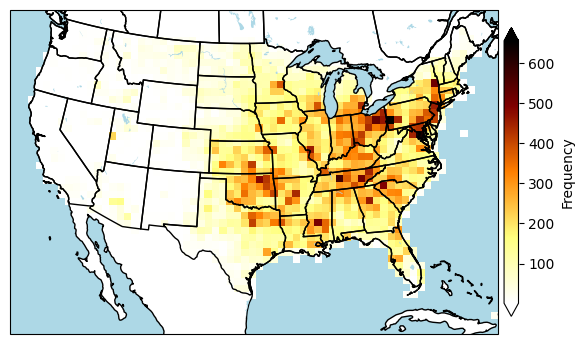

In [11]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = ds_cor.UP_HELI_MAX.values
data[data==0] = np.nan
c = ax.pcolormesh(ds_cor.lon.values, ds_cor.lat.values, data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, 701, 100)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)